* Dataset: 샘플과 정답(label)저장
* DataLoader: Dataset을 샘플에 쉽게 접근할 수 있도록 반복 가능한 객체(iterable)로 감싼다.

## 데이터셋 불러오기

*FashionMNIST 데이터셋*
* ```root```는 학습/테스트 데이터가 저장되는 경로
* ```train```은 학습용 또는 테스트용 데이터셋 여부 지정
* ```download=True```는 ```root```에 데이터가 없는 경우 인터넷에서 다운로드
* ```transform```과 ```target_transform```은 특징(feature)과 정답(label)의 변형(transform)을 지정

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [2]:
training_data =  datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

## 데이터셋을 반복하고 시각화


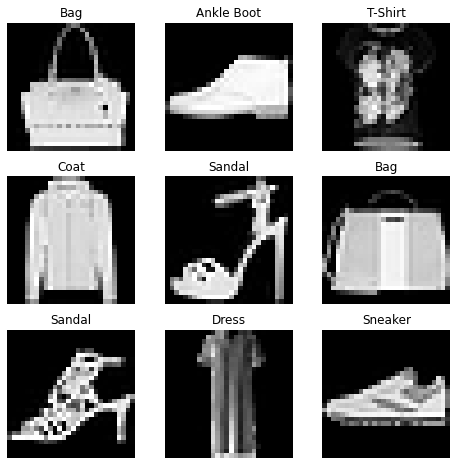

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기


사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: __init__, __len__, and __getitem__. 

FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # Dataset 객체가 생성될 때 한번만 실행, 이미지와 주석 파일이 포함된 디렉토리와 두가지 변형을 초기화
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        # 데이터셋의 샘플 개수 반환
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 샘플 반환
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0]) # 이미지 위치 식별
        image = read_image(img_path) # 이미지 텐서로 변환
        label = self.img_labels.iloc[idx,1] # 해당하는 정답(label) 가져오기
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {'image':image, 'label':label}
        return sample

## DataLoader로 학습용 데이터 준비
* ```Dataset```은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 한다.
* 모델을 학습할 때, 일반적으로 샘플들을 “미니배치(minibatch)”로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 한다.
* ```DataLoader```는 간단한 API로 이러한 복잡한 과정들을 추상화한 반복 가능한 객체(iteratable)

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 반복하기(iterate)
* ```DataLoader``` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 반복(iterate)할 수 있다.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


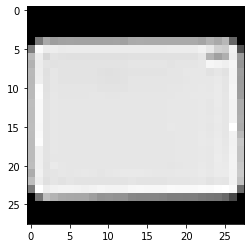

Label: 8


In [8]:
# 이미지와 정답(label)을 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {label}")